# Machine Learning Estimators for Wage Prediction 

We illustrate how to predict an outcome variable Y in a high-dimensional setting, where the number of covariates $p$ is large in relation to the sample size $n$. So far we have used linear prediction rules, e.g. Lasso regression, for estimation.
Now, we also consider nonlinear prediction rules including tree-based methods.

## Data

Again, we consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.
The preproccessed sample consists of $5150$ never-married individuals.

In [1]:
install.packages("librarian", quiet = T)
librarian::shelf(
  tidyverse
  , randomForest
  , rpart
  , glmnnet
  , gbm
  , rpart.plot
  , keras
  , hdm
  , quiet = T
)
data = read_csv("https://raw.githubusercontent.com/d2cml-ai/14.388_R/main/Data/wage2015_subsample_inference.csv", show_col_types = F)
dim(data)


  These packages will be installed:

  'glmnnet'

  It may take some time.



Warning message in stock(..., lib = lib, update_all = update_all, quiet = quiet, :
“
  These packages failed to install:

  'glmnnet'

  Check the spelling and capitalisation of the names.

  Are they Bioconductor packages? If so, please install Bioconductor
  (BiocManager and BiocBase).

  Are they from GitHub? If so, please supply both the GitHub username
  and package name, e.g. DesiQuintans/librarian”


Warning message in librarian::shelf(tidyverse, randomForest, rpart, glmnnet, gbm, :
“
  These packages are not installed, so they were not attached:

  'glmnnet'

  Did they fail to install? Are they spelled correctly?”


[1] 5150   21

The outcomes $Y_i$'s are hourly (log) wages of never-married workers living in the U.S. The raw regressors $Z_i$'s consist of a variety of characteristics, including experience, education and industry and occupation indicators.

In [2]:
Z <- data |> select(-c(lwage, wage)) # regressors
colnames(Z)

[1] "rownames" "sex"      "shs"      "hsg"      "scl"      "clg"     
 [7] "ad"       "mw"       "so"       "we"       "ne"       "exp1"    
[13] "exp2"     "exp3"     "exp4"     "occ"      "occ2"     "ind"     
[19] "ind2"

The following figure shows the weekly wage distribution from the US survey data.

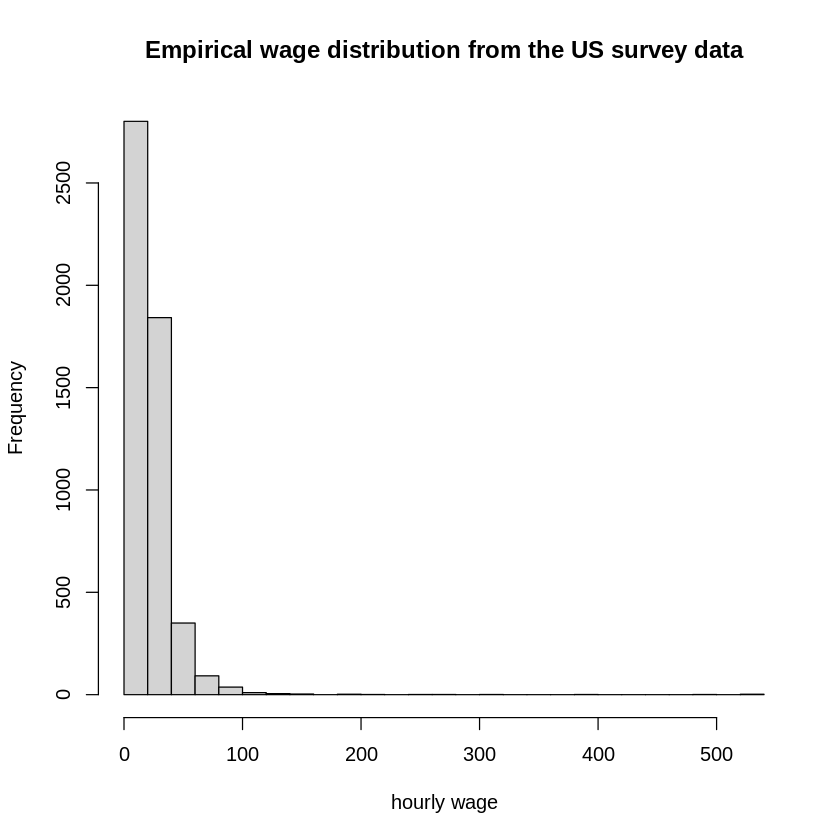

In [3]:
hist(data$wage, xlab= "hourly wage", main="Empirical wage distribution from the US survey data", breaks= 35)

Wages show a high degree of skewness. Hence, wages are transformed in almost all studies by
the logarithm.

## Analysis

Due to the skewness of the data, we are considering log wages which leads to the following regression model

$$log(wage) = g(Z) + \epsilon.$$

We will estimate the two sets of prediction rules: Linear and Nonlinear Models.
In linear models, we estimate the prediction rule of the form

$$\hat g(Z) = \hat \beta'X.$$
Again, we generate $X$ in two ways:
 
1. Basic Model:   $X$ consists of a set of raw regressors (e.g. gender, experience, education indicators, regional indicators).


2. Flexible Model:  $X$ consists of all raw regressors from the basic model plus occupation and industry indicators, transformations (e.g., ${exp}^2$ and ${exp}^3$) and additional two-way interactions.


To evaluate the out-of-sample performance, we split the data first.

In [4]:
set.seed(1234)
training <- sample(nrow(data), nrow(data)*(3/4), replace=FALSE)

data_train <- data[training,]
data_test <- data[-training,]

We construct the two different model matrices $X_{basic}$ and $X_{flex}$ for both the training and the test sample:

In [5]:
X_basic <-  "sex + exp1 + exp2+ shs + hsg+ scl + clg + mw + so + we + occ2+ ind2"
X_flex <- "sex + exp1 + exp2 + shs+hsg+scl+clg+occ2+ind2+mw+so+we + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)"
formula_basic <- as.formula(paste("lwage", "~", X_basic))
formula_flex <- as.formula(paste("lwage", "~", X_flex))

model_X_basic_train <- model.matrix(formula_basic,data_train)
model_X_basic_test <- model.matrix(formula_basic,data_test)
p_basic <- dim(model_X_basic_train)[2]
model_X_flex_train <- model.matrix(formula_flex,data_train)
model_X_flex_test <- model.matrix(formula_flex,data_test)
p_flex <- dim(model_X_flex_train)[2]

In [6]:
Y_train <- data_train$lwage
Y_test <- data_test$lwage

In [7]:
p_basic
p_flex

[1] 13

[1] 51

As known from our first lab, the basic model consists of $10$ regressors and the flexible model of $246$ regressors. Let us fit our models to the training sample using the two different model specifications. We are starting by running a simple ols regression. 

### OLS

We fit the basic model to our training data by running an ols regression and compute the mean squared error on the test sample.

In [8]:
# ols (basic model)
fit_lm_basic <- lm(formula_basic, data_train)  

In [9]:
# compute out-of-sample performance
yhat_lm_basic <- predict(fit_lm_basic, newdata = data_test)
cat("The mean squared error (MSE) using the basic model is equal to" , mean((Y_test - yhat_lm_basic)^2)) # MSE OLS (basic model)    

The mean squared error (MSE) using the basic model is equal to 0.2496282

To determine the out-of-sample $MSE$ and the standard error in one step, we can use the function *lm*:

In [10]:
MSE_lm_basic <- summary(lm((Y_test - yhat_lm_basic)^2~1))$coef[1:2]
MSE_lm_basic

[1] 0.24962821 0.01558452

We also compute the out-of-sample $R^2$:

In [11]:
R2_lm_basic <- 1 - MSE_lm_basic[1] / var(Y_test)
cat("The R^2 using the basic model is equal to", R2_lm_basic) # MSE OLS (basic model) 

The R^2 using the basic model is equal to 0.2185201

We repeat the same procedure for the flexible model.

In [12]:
# ols (flexible model)
fit_lm_flex <- lm(formula_flex, data_train)  
# Compute the Out-Of-Sample Performance
options(warn=-1)
yhat_lm_flex <- predict(fit_lm_flex, newdata = data_test)
MSE_lm_flex <- summary(lm((Y_test - yhat_lm_flex)^2~1))$coef[1:2]
R2_lm_flex <- 1 - MSE_lm_flex[1] / var(Y_test)
cat("The R^2 using the flexible model is equal to", R2_lm_flex) # MSE OLS (flexible model) 

The R^2 using the flexible model is equal to 0.2165618

We observe that ols regression works better for the basic model with smaller $p/n$ ratio. We are proceeding by running lasso regressions and its versions.

### Lasso, Ridge and Elastic Net


Considering the basic model, we run a lasso/post-lasso regression first and then we compute the measures for the out-of-sample performance. Note that applying the package *hdm* and the function *rlasso* we rely on a theory-based choice of the penalty level $\lambda$ in the lasso regression.

In [13]:
# lasso and versions
# library(hdm) 
fit.rlasso  <- rlasso(formula_basic, data_train, post=FALSE)
fit.rlasso.post <- rlasso(formula_basic, data_train, post=TRUE)
yhat.rlasso   <- predict(fit.rlasso, newdata=data_test)
yhat.rlasso.post   <- predict(fit.rlasso.post, newdata=data_test)

MSE.lasso <- summary(lm((Y_test-yhat.rlasso)^2~1))$coef[1:2]
MSE.lasso.post <- summary(lm((Y_test-yhat.rlasso.post)^2~1))$coef[1:2]

R2.lasso <- 1-MSE.lasso[1]/var(Y_test)
R2.lasso.post <- 1-MSE.lasso.post[1]/var(Y_test)
cat("The R^2 using the basic model is equal to",R2.lasso,"for lasso and",R2.lasso.post,"for post-lasso") # R^2 lasso/post-lasso (basic model) 

The R^2 using the basic model is equal to 0.2184129 for lasso and 0.2220093 for post-lasso

Now, we repeat the same procedure for the flexible model.

In [14]:
fit.rlasso.flex  <- rlasso(formula_flex, data_train, post=FALSE)
fit.rlasso.post.flex <- rlasso(formula_flex, data_train, post=TRUE)
yhat.rlasso.flex   <- predict(fit.rlasso.flex, newdata=data_test)
yhat.rlasso.post.flex   <- predict(fit.rlasso.post.flex, newdata=data_test)

MSE.lasso.flex <- summary(lm((Y_test-yhat.rlasso.flex)^2~1))$coef[1:2]
MSE.lasso.post.flex <- summary(lm((Y_test-yhat.rlasso.post.flex)^2~1))$coef[1:2]

R2.lasso.flex <- 1-MSE.lasso.flex[1]/var(Y_test)
R2.lasso.post.flex <- 1-MSE.lasso.post.flex[1]/var(Y_test)
cat("The R^2 using the flexible model is equal to",R2.lasso.flex,"for lasso and",R2.lasso.post.flex,"for post-lasso") # R^2 lasso/post-lasso (flexible model) 

The R^2 using the flexible model is equal to 0.2167083 for lasso and 0.2220093 for post-lasso

The lasso regression works better for the more complex model.

In contrast to a theory-based choice of the tuning parameter $\lambda$ in the lasso regression, we can also use cross-validation to determine the penalty level by applying the package *glmnet* and the function cv.glmnet. In this context, we also run a ridge and a elastic net regression by adjusting the parameter *alpha*.

In [15]:
library(glmnet)
fit.lasso.cv   <- cv.glmnet(model_X_basic_train, Y_train, family="gaussian", alpha=1)
fit.ridge   <- cv.glmnet(model_X_basic_train, Y_train, family="gaussian", alpha=0)
fit.elnet   <- cv.glmnet(model_X_basic_train, Y_train, family="gaussian", alpha=.5)

yhat.lasso.cv    <- predict(fit.lasso.cv, newx = model_X_basic_test)
yhat.ridge   <- predict(fit.ridge, newx = model_X_basic_test)
yhat.elnet   <- predict(fit.elnet, newx = model_X_basic_test)

MSE.lasso.cv <- summary(lm((Y_test-yhat.lasso.cv)^2~1))$coef[1:2]
MSE.ridge <- summary(lm((Y_test-yhat.ridge)^2~1))$coef[1:2]
MSE.elnet <- summary(lm((Y_test-yhat.elnet)^2~1))$coef[1:2]

R2.lasso.cv <- 1-MSE.lasso.cv[1]/var(Y_test)
R2.ridge <- 1-MSE.ridge[1]/var(Y_test)
R2.elnet <- 1-MSE.elnet[1]/var(Y_test)

# R^2 using cross-validation (basic model) 
cat("R^2 using cross-validation for lasso, ridge and elastic net in the basic model:",R2.lasso.cv,R2.ridge,R2.elnet)

Loading required package: Matrix




Attaching package: ‘Matrix’




The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




Loaded glmnet 4.1-4



R^2 using cross-validation for lasso, ridge and elastic net in the basic model: 0.2203463 0.2055758 0.2192991

Note that the following calculations for the flexible model require significant computation time.

In [16]:
fit.lasso.cv.flex   <- cv.glmnet(model_X_flex_train, Y_train, family="gaussian", alpha=1)
fit.ridge.flex   <- cv.glmnet(model_X_flex_train, Y_train, family="gaussian", alpha=0)
fit.elnet.flex   <- cv.glmnet(model_X_flex_train, Y_train, family="gaussian", alpha=.5)

yhat.lasso.cv.flex    <- predict(fit.lasso.cv.flex , newx = model_X_flex_test)
yhat.ridge.flex    <- predict(fit.ridge.flex , newx = model_X_flex_test)
yhat.elnet.flex    <- predict(fit.elnet.flex , newx = model_X_flex_test)

MSE.lasso.cv.flex  <- summary(lm((Y_test-yhat.lasso.cv.flex )^2~1))$coef[1:2]
MSE.ridge.flex  <- summary(lm((Y_test-yhat.ridge.flex )^2~1))$coef[1:2]
MSE.elnet.flex  <- summary(lm((Y_test-yhat.elnet.flex )^2~1))$coef[1:2]

R2.lasso.cv.flex  <- 1-MSE.lasso.cv.flex [1]/var(Y_test)
R2.ridge.flex  <- 1-MSE.ridge.flex [1]/var(Y_test)
R2.elnet.flex  <- 1-MSE.elnet.flex [1]/var(Y_test)

# R^2 using cross-validation (flexible model) 
cat("R^2 using cross-validation for lasso, ridge and elastic net in the flexible model:",R2.lasso.cv.flex,R2.ridge.flex,R2.elnet.flex)

R^2 using cross-validation for lasso, ridge and elastic net in the flexible model: 0.2201523 0.2062207 0.2211247

The performance of the lasso regression with cross-validated penalty is quite similar to the performance of lasso using a theoretical based choice of the tuning parameter.

## Non-linear models

Besides linear regression models, we consider nonlinear regression models to build a predictive model. We are apply regression trees, random forests, boosted trees and neural nets to estimate the regression function $g(X)$. First, we load the relevant libraries.

In [17]:
library(randomForest)
library(rpart)
library(nnet)
library(gbm)
library(rpart.plot)
library(keras)

and we illustrate the application of regression trees.

### Regression Trees

We fit a regression tree to the training data using the basic model. The variable *cp* controls the complexity of the regression tree, i.e. how deep we build the tree.

cex 0.2   xlim c(0, 1)   ylim c(0, 1)


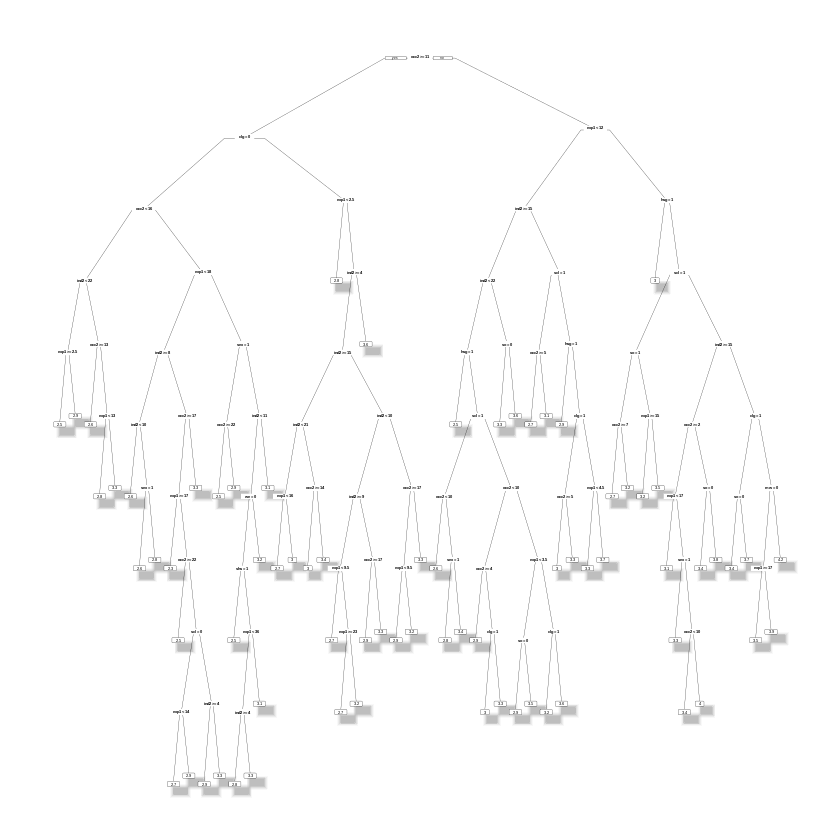

In [18]:
# fit the tree
fit.trees <- rpart(formula_basic, data_train,cp = 0.001)
prp(fit.trees,leaf.round=1, space=2, yspace=2,split.space=2,shadow.col = "gray",trace = 1) # plotting the tree

An important method to improve predictive performance is called "Pruning the Tree". This
means the process of cutting down the branches of a tree. We apply pruning to the complex tree above to reduce the depth. Initially, we determine the optimal complexity of the regression tree.

In [19]:
bestcp<- fit.trees$cptable[which.min(fit.trees$cptable[,"xerror"]),"CP"]
bestcp

[1] 0.001884444

Now, we can prune the tree and visualize the prediction rule.

cex 0.45   xlim c(0, 1)   ylim c(0, 1)


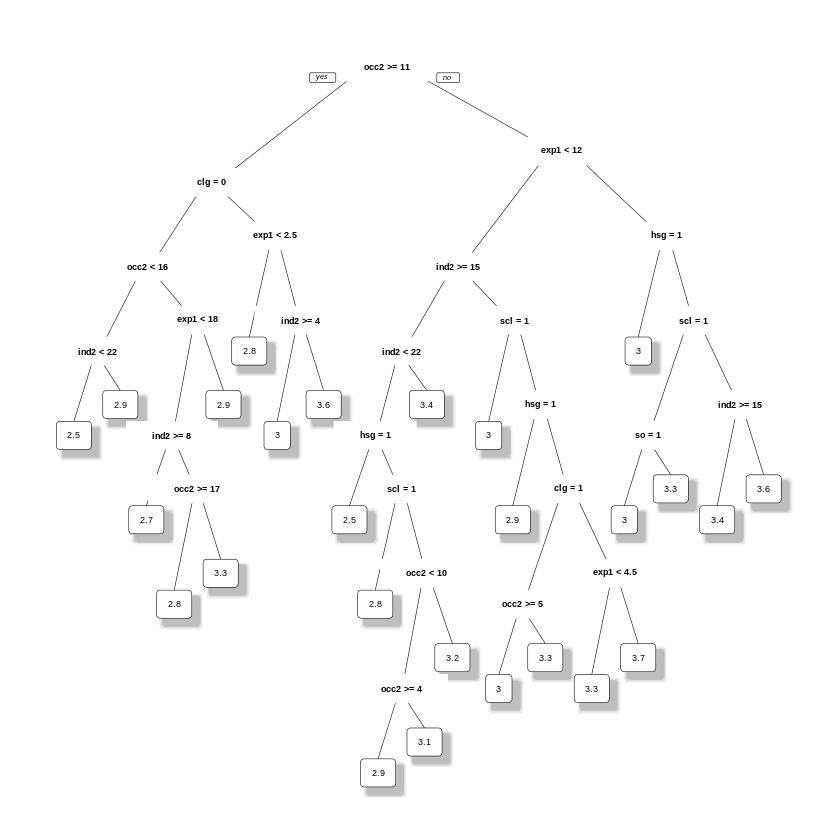

In [20]:
fit.prunedtree <- prune(fit.trees,cp=bestcp)
prp(fit.prunedtree,leaf.round=1, space=3, yspace=3, split.space=7, shadow.col = "gray",trace = 1,yesno=1)

E.g., in the pruned tree the predicted hourly log wage for high-school graduates with more than $9.5$ years of experience is $2.8$, and otherwise is $2.6$.

Finally, we calculate the mean-squared error and the $R^2$ on the test sample to evaluate the out-of-sample performance of the pruned tree.

In [21]:
yhat.pt <- predict(fit.prunedtree,newdata=data_test)
MSE.pt <- summary(lm((Y_test-yhat.pt)^2~1))$coef[1:2]
R2.pt  <- 1-MSE.pt[1]/var(Y_test)

# R^2 of the pruned tree
cat("R^2 of the pruned tree:",R2.pt)

R^2 of the pruned tree: 0.2250066

### Random Forest and Boosted Trees

In the next step, we apply the more advanced tree-based methods: random forest and boosted trees.

In [22]:
## Applying the methods
# random forest
fit.rf       <- randomForest(formula_basic, ntree=2000, nodesize=5, data=data_train)
# for tuning: adjust input "mtry" to change the number of variables randomly sampled as candidates at each split

# boosting
fit.boost   <- gbm(formula_basic, data=data_train, distribution= "gaussian", bag.fraction = .5, interaction.depth=2, n.trees=1000, shrinkage=.01)
best.boost  <- gbm.perf(fit.boost, plot.it = FALSE) # cross-validation to determine when to stop

## Evaluating the methods
yhat.rf       <- predict(fit.rf, newdata=data_test) # prediction
yhat.boost    <- predict(fit.boost, newdata=data_test, n.trees=best.boost)

MSE.rf       = summary(lm((Y_test-yhat.rf)^2~1))$coef[1:2]
MSE.boost    = summary(lm((Y_test-yhat.boost)^2~1))$coef[1:2]
R2.rf  <- 1-MSE.rf[1]/var(Y_test)
R2.boost  <- 1-MSE.boost[1]/var(Y_test)

# printing R^2
cat("R^2 of the random forest and boosted trees:",R2.rf,R2.boost)


To conclude, let us have a look at our results.

## Results

In [23]:
# library(xtable)
table<- matrix(0, 15, 3)
table[1,1:2]   <- MSE_lm_basic
table[2,1:2]   <- MSE_lm_flex
table[3,1:2]   <- MSE.lasso
table[4,1:2]   <- MSE.lasso.post
table[5,1:2]   <- MSE.lasso.flex
table[6,1:2]   <- MSE.lasso.post.flex
table[7,1:2]   <- MSE.lasso.cv
table[8,1:2]   <- MSE.ridge
table[9,1:2]   <- MSE.elnet
table[10,1:2]   <- MSE.lasso.cv.flex
table[11,1:2]  <- MSE.ridge.flex
table[12,1:2]  <- MSE.elnet.flex
table[13,1:2]  <- MSE.rf
table[14,1:2]  <- MSE.boost
table[15,1:2]  <- MSE.pt

table[1,3]   <- R2_lm_basic
table[2,3]   <- R2_lm_flex
table[3,3]   <- R2.lasso
table[4,3]   <- R2.lasso.post
table[5,3]   <- R2.lasso.flex
table[6,3]   <- R2.lasso.post.flex
table[7,3]   <- R2.lasso.cv
table[8,3]   <- R2.ridge
table[9,3]   <- R2.elnet
table[10,3]   <- R2.lasso.cv.flex
table[11,3]  <- R2.ridge.flex
table[12,3]  <- R2.elnet.flex
table[13,3]  <- R2.rf
table[14,3]  <- R2.boost
table[15,3]  <- R2.pt

colnames(table)<- c("MSE", "S.E. for MSE", "R-squared")
rownames(table)<- c("Least Squares (basic)","Least Squares (flexible)", "Lasso", "Post-Lasso","Lasso (flexible)","Post-Lasso (flexible)", 
                    "Cross-Validated lasso", "Cross-Validated ridge","Cross-Validated elnet","Cross-Validated lasso (flexible)","Cross-Validated ridge (flexible)","Cross-Validated elnet (flexible)",  
                    "Random Forest","Boosted Trees", "Pruned Tree")
table

,MSE,S.E. for MSE,R-squared
Least Squares (basic),0.2496282,0.01558452,0.2185201
Least Squares (flexible),0.2502538,0.01557896,0.2165618
Lasso,0.2496625,0.01511149,0.2184129
Post-Lasso,0.2485137,0.01537409,0.2220093
Lasso (flexible),0.2502069,0.01503037,0.2167083
Post-Lasso (flexible),0.2485137,0.01537409,0.2220093
Cross-Validated lasso,0.2490449,0.01519297,0.2203463
Cross-Validated ridge,0.2537630,0.01536035,0.2055758
Cross-Validated elnet,0.2493794,0.01520680,0.2192991
Cross-Validated lasso (flexible),0.2491068,0.01512894,0.2201523


Above, we have displayed the results for a single split of data into the training and testing part. The table shows the test MSE in column 1 as well as the standard error in column 2 and the test $R^2$ in column 3. 

We see that the prediction rule produced by the Elastic Net using the flexible model performs the best here, giving the lowest test MSE. Cross-Validated Lasso and Ridge, perform nearly as well. For any two of these methods, their testing MSEs are within one standard error of each other. Remarkably, OLS on a simple model performs extremely well, almost as well as best tree based method Random Forest. On the other hand, OLS on a flexible model with many regressors performs very poorly giving the highest test MSE. Notice that the nonlinear models, e.g. Random Forest, are not tuned. Thus, there is a lot of potential to improve the performance of the nonlinear methods we used in the analysis.

## Ensemble learning

In the final step, we can build a prediction model by combining the strengths of the models we considered so far. This ensemble method is of the form

$$ f(x) = \sum_{k=1}^K \alpha_k f_k(x) $$
    
where the $f_k$'s denote our prediction rules from the table above and the $\alpha_k$'s are the corresponding weights.

We focus on the prediction rules based on OLS, Post-Lasso, Elastic Net, Pruned Tree, Random Forest, Boosted Trees, and Neural Network and combine these methods into an ensemble method. The appropriate weights can be determined by a simple ols regression:

In [24]:
ensemble.ols <- summary(lm(Y_test~ yhat_lm_basic + yhat.rlasso.post.flex + yhat.elnet.flex+ yhat.pt+ yhat.rf + yhat.boost))
ensemble.ols


Call:
lm(formula = Y_test ~ yhat_lm_basic + yhat.rlasso.post.flex + 
    yhat.elnet.flex + yhat.pt + yhat.rf + yhat.boost)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7261 -0.2821 -0.0141  0.2717  3.6299 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -0.13636    0.28142  -0.485  0.62809    
yhat_lm_basic         -0.05963    0.18749  -0.318  0.75050    
yhat.rlasso.post.flex  0.24141    0.41866   0.577  0.56429    
yhat.elnet.flex       -0.18802    0.57863  -0.325  0.74529    
yhat.pt                0.01050    0.10543   0.100  0.92070    
yhat.rf                0.48543    0.09208   5.272 1.58e-07 ***
yhat.boost             0.55427    0.17909   3.095  0.00201 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4789 on 1281 degrees of freedom
Multiple R-squared:  0.2855,	Adjusted R-squared:  0.2821 
F-statistic: 85.31 on 6 and 1281 DF,  p-value: < 2.2e-16


Alternatively, we can determine the weights via lasso regression. 

In [25]:
ensemble.lasso <- summary(rlasso(Y_test~ yhat_lm_basic + yhat.rlasso.post.flex + yhat.elnet.flex+ yhat.pt+ yhat.rf + yhat.boost))
ensemble.lasso


Call:
rlasso.formula(formula = Y_test ~ yhat_lm_basic + yhat.rlasso.post.flex + 
    yhat.elnet.flex + yhat.pt + yhat.rf + yhat.boost)

Post-Lasso Estimation:  TRUE 

Total number of variables: 6
Number of selected variables: 2 

Residuals: 
     Min       1Q   Median       3Q      Max 
-1.72393 -0.28094 -0.01085  0.27243  3.61820 

                      Estimate
(Intercept)             -0.196
yhat_lm_basic            0.000
yhat.rlasso.post.flex    0.000
yhat.elnet.flex          0.000
yhat.pt                  0.000
yhat.rf                  0.475
yhat.boost               0.589

Residual standard error: 0.4779
Multiple R-squared:  0.2851
Adjusted R-squared:  0.284
Joint significance test:
 the sup score statistic for joint significance test is 3.399 with a p-value of 0.058



Call:
rlasso.formula(formula = Y_test ~ yhat_lm_basic + yhat.rlasso.post.flex + 
    yhat.elnet.flex + yhat.pt + yhat.rf + yhat.boost)

Coefficients:
          (Intercept)          yhat_lm_basic  yhat.rlasso.post.flex  
              -0.1963                 0.0000                 0.0000  
      yhat.elnet.flex                yhat.pt                yhat.rf  
               0.0000                 0.0000                 0.4750  
           yhat.boost  
               0.5892  


The estimated weights are shown in the following table.

In [26]:
table<- matrix(0, 7, 2)
table[1:7,1]   <- ensemble.ols$coef[1:7]
table[1:7,2]   <- ensemble.lasso$coef[1:7]

colnames(table)<- c("Weight OLS", "Weight Lasso")
rownames(table)<- c("Constant","Least Squares (basic)","Post-Lasso (flexible)", "Cross-Validated elnet (flexible)", "Pruned Tree",
                    "Random Forest","Boosted Trees")
table

,Weight OLS,Weight Lasso
Constant,-0.13635940,-0.1963149
Least Squares (basic),-0.05963050,0.0000000
Post-Lasso (flexible),0.24140935,0.0000000
Cross-Validated elnet (flexible),-0.18801716,0.0000000
Pruned Tree,0.01049777,0.0000000
Random Forest,0.48543389,0.4749684
Boosted Trees,0.55426895,0.5891756


Further, the $R^2$ for the test sample improves from $30\%$ obtained by OLS to about $31\%$ obtained by the ensemble method. We see that it is very powerful to aggregate prediction rules into an ensemble rule. Nevertheless, it is worth noticing that we should compare the ensemble method and the single rules on an additional validation set to ensure a fair comparison.